# - Module 4 Final Project - 
# *Zillow Time Series Data Analysis*
<br/>
Student Name: Isabella Lindgren <br/>
Course: Part Time Data Science <br/>
Instructor: Eli <br/>
Presentation Date: TBD


## Objective

For this project, our goal is to interpret and answer the following question: <br/>
> **What are the top 5 zip codes to invest in?**

I approached this question as a consultant for Citi Habitats Real Estate in New York City. There are over 100 zipcodes in the five boroughs of New York: the Bronx, Brooklyn, Manhattan, Kings County, and Richmond County (Staten Island). It is important to consider not only the profitability of the area, but the risk factors as well that may influence what makes a "good" investment property.  <br/>

 1.  Profitability/ROI
 2.  Average household income
 3.  Vacancies in the area
 4.  Rate of Employment in the area

# Import Necessary Libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
plt.style.use('seaborn')
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
from ast import literal_eval
import warnings
warnings.filterwarnings("ignore")

#!pip install pyshp
#import shapefile as shp

# Define Useful Functions

In [66]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [67]:
# define a function to convert from long format to short format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','SizeRank','RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted.set_index('time',inplace=True)
    melted.dropna(inplace=True)
    return melted
    #return melted.groupby('time').aggregate({'value':'mean'})


In [68]:
def train_test_split(data):
    
    train = []
    test = []
    
    for i in range(0, len(data)):
    #Split datasets into training and testing
        train_df = data.iloc[:training_n]
        test_df = data.iloc[training_n:]
    
    #Append training and test datasets to list
        train.append(train_df)
        test.append(test_df)
    return train, test

In [69]:
# Assess stationarity of time series
def check_stationarity(df, zipcode):
    
    # Calculate rolling mean and standard deviation using a 12 month window
    rolmean = df.rolling(window=12, center=False).mean()
    rolstd = df.rolling(window=12, center=False).std()
    
    # Plot rolling mean and standard deviation against the original time series data
    fig = plt.figure(figsize=(14,7))
    original = plt.plot(df, label='Original')
    mean = plt.plot(rolmean, label = 'Rolling Mean')
    std = plt.plot(rolstd, label = 'Rolling Standard Deviation')
    plt.title(f"Staionarity Check for Zipcode {zipcode}")
    plt.legend()
    plt.show(block=False)
    
    # Conduct a Dickey-Fuller test on time series to provide a statistical measure of stationarity
    dftest = adfuller(df['value'])
    
    # Create an easy-to-read series with key Dickey-Fuller parameters
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print('Results of Dickey-Fuller Test')
    print(dfoutput)

In [70]:
# Assess seasonality of data 
def check_seasonality(df, col):
    # Use Statsmodels seasonal_decompose function to split time series variation into trend, seasonal variation and white noise
    result = seasonal_decompose(df)
    # Plot Trend, Seasonal and Residual on 3 consecutive axes
    result.trend.plot(ax=axes[0][col])
    axes[0][col].set_ylabel('Trend')
    result.seasonal.plot(ax=axes[1][col])
    axes[1][col].set_ylabel('Seasonal')
    result.resid.plot(ax=axes[2][col])
    axes[2][col].set_ylabel('Residual')

In [71]:
# Plot the autocorrelation and partial autocorrelation functions for a given dataset and number of lags
def check_autocorrelation(df, lags, col):
    plot_acf(df, lags=lags, ax=ax[0][col])
    plot_pacf(df, lags=lags, ax=ax[1][col])

# Load the Data

In [72]:
df = pd.read_csv('zillow_data.csv')
df.head() # preview

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


We can see from the preview that the data is in a wide format. Each date is a column. This will need to be reformatted in order to perform time series analysis. We can also see that the dates are in YYYY-MM format.

**Variable Descriptions** <br/>
 - RegionID: Zipcode
 - RegionName: Number assigned by Zillow
 - City: City where zip code is located
 - State: State where zip code is located
 - Metro: General Metropolitan Area
 - CountyName: Name of the county in which the zip code is located
 - SizeRank: ranks the zip code by degree of urbanization. Higher rank is more urbanized.
 - The values in the columns of the dates represent the median house cost of that particular zipcode in USD

# Data Preprocessing

It is important to always ensure that the dataset is clean and as complete as possible in order to create a successful model. First, we will narrow down the dataset so it only includes the scope of the five boroughs of New York. Then, we will identify any missing data and adjust accordingly. 

In [73]:
# Let's preview the info of the original dataset
# We can see that there are 14723 zipcodes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [74]:
# create a query that extracts all data where State is NY, City is New York, and Metro is New York
df.query('State =="NY" and City =="New York" and Metro == "New York"', inplace = True)
df.head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
13,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
21,61703,10128,New York,NY,New York,New York,22,3676700.0,3704200.0,3729600.0,...,7410100,7422400,7417600,7427300,7371400,7342700,7353300,7350300,7363000,7386600
35,61802,10462,New York,NY,New York,Bronx,36,154300.0,154300.0,154400.0,...,432800,436100,439900,443500,444100,443900,446000,446400,447200,450200
36,61796,10456,New York,NY,New York,Bronx,37,NaN,NaN,NaN,...,357900,357100,356500,357200,362000,368500,374100,379800,388100,394400
46,61803,10463,New York,NY,New York,Bronx,47,180100.0,181000.0,181900.0,...,680800,684500,692000,700900,710200,726900,744500,757000,769400,778700
47,62040,11230,New York,NY,New York,Kings,48,230100.0,230800.0,231500.0,...,1079200,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400


In [75]:
# Now we can see that there are 114 zipcodes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 6 to 11037
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 243.1+ KB


Now that we have narrowed the scope of our data set, let's check if there are any missing values in our remaining data. 

In [76]:
# Let's rename this df to NY_df
NY_df = df
NY_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
13,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300


In [77]:
# Create a new column with number of missing values for each zipcode
cols = list(NY_df.columns[7:])
NY_df['NumValuesMissing'] = NY_df[cols].isna().sum(axis=1)

In [78]:
NY_df['NumValuesMissing'].value_counts()

0      104
93       6
105      1
87       1
213      1
189      1
Name: NumValuesMissing, dtype: int64

We can see that the majority of zipcodes (104) are not missing any data. 10 zipcodes are missing many (87-213) values. Since these observations are monthly, 12 observations are 1 years worth of data. Since the 10 zipcodes are missing more than a years' worth of data, we will drop them from the data frame.

In [79]:
# Create dataframe with all the zipcodes missing values
missingdata = NY_df[NY_df['NumValuesMissing']>12].sort_values(['NumValuesMissing'], ascending=False)

# Drop missing values with more than 1 year of observations missing
NY_df.drop(index=missingdata.index, inplace=True)

In [80]:
# Double check that there are no more zipcodes that are missing values
NY_df[NY_df['NumValuesMissing']>0]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,NumValuesMissing


Great! We can see that there are no more zipcodes with missing data. Next, we will transform the dates to datetime format for analysis.

In [81]:
# Let's drop the 'NumValuesMissing' column since it is no longer needed
NY_df = NY_df.drop(['NumValuesMissing'], axis=1)

# Now let's convert columns with dates to datetime format
pd.to_datetime(NY_df.columns[7:], format='%Y-%m')

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

# Zipcode Selection

My strategy is to determine which zipcodes are highly ranked in Urbanization, have the greatest mean house price growth historically, and present the lowest risk.

First, Let's determine which zipcodes are ranked in the top 25% of urbanized areas according to SizeRank.

In [82]:
#Get zipcodes with a sizerank in the top 25% (highly urbanized zipcodes).
print(NY_df.SizeRank.describe(),'\n')

#Calculate the 25% cutoff value.
sr_25 = NY_df.SizeRank.quantile(q=0.25)
print(f'Size Rank 25% cutoff value: {sr_25}')

#Get data frame with selected zipcodes. Keep values and zipcodes only.
zc_top25 = NY_df[NY_df['SizeRank']<sr_25].drop(['RegionID','City',
                                                       'State','Metro','CountyName',
                                                       'SizeRank'],axis=1)
print(f'Amount of zipcodes: {len(zc_top25)}')
print("Top Urbanized Zipcodes: ", zc_top25['RegionName'].unique())

count      104.000000
mean      2961.884615
std       2886.991024
min          7.000000
25%        298.250000
50%       2012.500000
75%       5170.250000
max      11038.000000
Name: SizeRank, dtype: float64 

Size Rank 25% cutoff value: 298.25
Amount of zipcodes: 26
Top Urbanized Zipcodes:  [10467 11226 11375 11235 10128 10462 10463 11230 11209 11212 11214 11221
 11229 11377 11234 11355 10314 11215 11211 11385 11373 11233 11236 11372
 11218 11223]


Now that we have the top urbanized zip codes, let's look at the median house price in these zipcodes. The zip code's average house price should be between 1.5 decile below and 1.5 decile above the zip code's 1 year median value.

In [83]:
zc_top25['yr_avg']=zc_top25.iloc[:,-12:].mean(skipna=True, axis=1)

#Get zipcodes with an average value 1.5 decile above the median and 1.5 deciles below.
print(zc_top25['yr_avg'].describe(),'\n')

#Calculate the 65% cutoff value (1 decile above).
q_65 = zc_top25['yr_avg'].quantile(q=0.65)
print(f'Average Value 65% cutoff value: {round(q_65,2)}')

#Calculate the 35% cutoff value (1.5 deciles below).
q_35 = zc_top25['yr_avg'].quantile(q=0.35)
print(f'Average Value 35% cutoff value: {round(q_35,2)}')

#Get data frame with selected zipcodes.
zc_pref = zc_top25[(zc_top25['yr_avg']<q_65) & (zc_top25['yr_avg']>q_35)]
print(f'Amount of zipcodes: {len(zc_pref)}')

print("Top preferred Zipcodes: ", zc_pref['RegionName'].unique())

count    2.600000e+01
mean     1.107354e+06
std      1.333859e+06
min      4.033083e+05
25%      6.542979e+05
50%      8.106083e+05
75%      1.007850e+06
max      7.377192e+06
Name: yr_avg, dtype: float64 

Average Value 65% cutoff value: 901597.92
Average Value 35% cutoff value: 743947.92
Amount of zipcodes: 8
Top preferred Zipcodes:  [11226 11235 11214 11377 11355 11373 11233 11372]


In [84]:
zc_pref['ROI']= (zc_pref['2018-04']/zc_pref['1996-04'])-1

#Calculate standard deviation of monthly values
zc_pref['std']=zc_pref.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
zc_pref['mean']=zc_pref.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
zc_pref['CV']=zc_pref['std']/zc_pref['mean']

#Show calculated values
zc_pref[['RegionName','std','mean','ROI','CV']].head()

#Descriptive statistics of coefficients of variance.
print(zc_pref.CV.describe())
#Define upper limit of CV according to risk profile.
upper_cv = zc_pref.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')
#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best5 = zc_pref[zc_pref['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
zc_best5[['RegionName','ROI','CV']]

count    8.000000
mean     0.404202
std      0.051916
min      0.348941
25%      0.377986
50%      0.383406
75%      0.415742
max      0.510009
Name: CV, dtype: float64

CV upper limit: 0.39044914148935705

 Best 5 Zipcodes:


,RegionName,ROI,CV
228,11372,3.531020,0.379479
140,11373,3.429875,0.379764
58,11214,3.419372,0.387049
13,11235,3.284514,0.348941
85,11377,3.259777,0.373506


Zipcode: 11372 <br/>
Location: Jackson Heights, Queens
<br/><br/>
Zipcode: 11373 <br/>
Location: Elmhurst, Queens
<br/><br/>
Zipcode: 11214 <br/>
Location: Bath Beach/Bensonhurst, Brooklyn
<br/><br/>
Zipcode: 11235 <br/>
Location: Brighton Beach/Manhattan Beach/Sheepshead Bay, Brooklyn
<br/><br/>
Zipcode: 11377 <br/>
Location: Woodside, Queens

In [85]:
#NY_df.set_index('RegionName')
# NY_df.head()
#top5_df = NY_df.iloc[NY_df['RegionName'][11372, 11373, 11214, 11235, 11377]]

In [86]:
zc_best5.head(5)

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-12,2018-01,2018-02,2018-03,2018-04,yr_avg,ROI,std,mean,CV
228,11372,190200.0,190800.0,191700.0,192600.0,193500.0,194300.0,195100.0,196100.0,197300.0,...,845900,841900,848800,860100,861800,845958.333333,3.531020,188423.540817,496531.698113,0.379479
140,11373,175400.0,175800.0,176400.0,177000.0,177600.0,178200.0,178800.0,179800.0,180900.0,...,766900,773700,776100,775900,777000,760033.333333,3.429875,173459.227313,456755.471698,0.379764
58,11214,191000.0,191200.0,191500.0,191900.0,192100.0,192400.0,192800.0,193200.0,193800.0,...,826300,827600,830500,837300,844100,817275.000000,3.419372,184170.459178,475832.452830,0.387049
13,11235,190500.0,191000.0,191500.0,192000.0,192500.0,193000.0,193600.0,194300.0,195300.0,...,799700,806600,810600,813400,816200,789966.666667,3.284514,166512.159532,477193.207547,0.348941
85,11377,179000.0,178900.0,179000.0,179000.0,179100.0,179200.0,179300.0,179700.0,180200.0,...,749900,750300,753000,758200,762500,745508.333333,3.259777,166911.849275,446878.113208,0.373506


# Exploratory Data Analysis and Visualization

### Percentage Growth

Prior to 2008, the US experienced a major housing bubble caused by inflows of money into housing markets, loose lending conditions, and government policy to promote home-ownership. In 2008, there was a financial crisis in the US and the housing bubble burst causing the largest price drop in homes in history and the worst depression since the Great Depression of the 1930's. The economy and housing market has been recovering since 2008, but the rate of growth is not nearly as great as in the 1990's to early 2000's. It is important to take into account significant historical context when considering our data.
<br/><br/>
Let's look at the percentage growth in mean house price in two time frames: 1998-2008 and 2008-2018. We can expect to see the growth rate in the first time frame to be larger than the second due to the history. 

In [87]:
# Create dataframe of mean house price in NY
avgpriceNY = NY_df.groupby(['State']).mean()
#Drop unnecessary data
avgpriceNY.drop(['RegionID', 'RegionName', 'SizeRank'], axis=1, inplace=True)
avgpriceNY

# Compute % growth across the two specified periods
avgpriceNY['Growth 2008 to 2018'] = ((avgpriceNY['2018-04'] - avgpriceNY['2008-01'])/avgpriceNY['2008-01'])*100
avgpriceNY['Growth 1998 to 2008'] = ((avgpriceNY['2008-01'] - avgpriceNY['1998-01'])/avgpriceNY['1998-01'])*100

print("The growth in house prices from 2008-2019 in ", avgpriceNY['Growth 2008 to 2018'])
print("The growth in house prices from 1998-2008 in ", avgpriceNY['Growth 1998 to 2008'])

The growth in house prices from 2008-2019 in  State
NY    34.991451
Name: Growth 2008 to 2018, dtype: float64
The growth in house prices from 1998-2008 in  State
NY    157.84551
Name: Growth 1998 to 2008, dtype: float64


In [88]:
avgpriceNY

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Growth 2008 to 2018,Growth 1998 to 2008
State,,,,,,,,,,,,,,,,,,,,,
NY,214819.230769,215233.653846,215698.076923,216186.538462,216720.192308,217312.5,217988.461538,218839.423077,219902.884615,220883.653846,...,774016.346154,778725.961538,781374.038462,783982.692308,787730.769231,791819.230769,798902.884615,806192.307692,34.991451,157.84551


We can see that the percentage in house price growth is much lower from 2008-2018 compared to the percentage growth from 1998-2008. This is consistent with the historical data.

# May Take Out!!!
<br/>It is also important to take into account the demographics of the areas we are looking to invest in. 

In [89]:
# Open source data 
census_data = pd.read_csv('combined_csv.csv')
census_data.head()

,Id,Id2,Geography,UnweightedSampleCountPop,HousingUnitsEstimate,TotalPop,WorkerPop,TotalHouseholds,MalePop,FemalePop,TotalFams,EnrolledSchool,BelowPov12,HouseholdIncome,MedianIncome,UnemployRate,HousingUnitNoMortgage
0,0500000US36001,36001,"Albany County, New York",24466,10344,308580,223959,291211,149287,159293,68180,83298,36325,125376,125376,5.3,26283
1,0500000US36003,36003,"Allegany County, New York",10383,5138,47400,16564,42404,24013,23387,11808,13739,6992,18124,18124,7.3,7012
2,0500000US36005,36005,"Bronx County, New York",88079,32864,1455846,381671,1413891,685636,770210,326296,406578,422197,495356,495356,11.6,39054
3,0500000US36007,36007,"Broome County, New York",18278,7870,196124,91025,185709,96409,99715,46737,53058,31795,78821,78821,7.2,23175
4,0500000US36009,36009,"Cattaraugus County, New York",14440,7042,78175,29681,75461,38739,39436,19976,18171,12777,31723,31723,7.0,11225


## Integrating ArcGIS and Python data

It may be easier to visualize this data on a map - so I will try to overlay our data on a shapefile taken from https://data.cityofnewyork.us/widgets/i8iw-xf4u using the method described in https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

In [113]:
# I downloaded the open source shapefile data from the NYC open database and set directory path
shp_path = """C://Users/isali/Flatiron/Final_Projects/dsc-mod-4-project-online-ds-pt-061019/NYC_Zipcodes_GIS/ZIP_CODE_040114.shp"""
sf = shp.Reader(shp_path) # download shapefile into python

In [114]:
len(sf.shapes()) # there are 263 shapes in this shapefile

263

In [115]:
sf.records()[1] # We can see the information stored in each shape i.e. zipcode, borough, county etc

Record #1: ['11213', '0', 'Brooklyn', 62426.0, 29631004.437939, 'NY', 'Kings', '36', '047', 'http://www.usps.com/', 0.0, 0.0]

In [116]:
# Create a function to turn shapefile in pandas dataframe
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    sf_df = pd.DataFrame(columns=fields, data=records)
    sf_df = sf_df.assign(coords=shps)
    return sf_df

In [117]:
sf_df = read_shapefile(sf)
sf_df.shape # we have 13 features for each shape

(263, 13)

In [118]:
sf_df.sample(5) #preview of 5 shapes - we can see coordinate data in the last column

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,coords
93,11378,0,Maspeth,35473.0,6.626054e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"[(1008954.7077964842, 205203.58275288343), (10..."
50,10048,0,New York,0.0,9.727884e+05,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"[(981026.764964804, 197865.69027645886), (9810..."
230,10106,1,New York,0.0,3.105255e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"[(989460.1404864788, 218179.62930729985), (989..."
237,10081,1,New York,0.0,3.024051e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"[(981833.8319202214, 197034.0626746267), (9816..."
26,10465,0,Bronx,42012.0,1.084237e+08,NY,Bronx,36,005,http://www.usps.com/,0.0,0.0,"[(1028758.8702878058, 243777.01840113103), (10..."


In [119]:
def plot_shape(id, s=None):
    """ PLOTS A SINGLE SHAPE 
    This funtion plots the shape (polygon) of the zipcode based on the coordinates 
    and calculates and returns the medium point of that specific shape (x0, y0) which will 
    be used to define where to print the index"""
    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon,y_lat) 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
    # use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
    return x0, y0

In [120]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

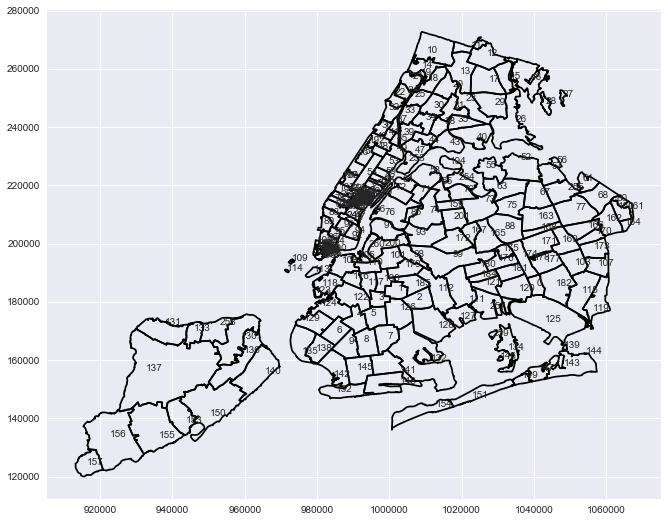

In [121]:
plot_map(sf)

In [122]:
def calc_color(data, color=None):
        if color   == 1: color_sq = ['#dadaebFF','#bcbddcF0','#9e9ac8F0',
                        '#807dbaF0','#6a51a3F0','#54278fF0']; colors = 'Purples';
        elif color == 2: color_sq = ['#c7e9b4','#7fcdbb','#41b6c4',
                        '#1d91c0','#225ea8','#253494']; colors = 'YlGnBu';
        elif color == 3: color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd',
                        '#969696','#636363','#252525']; colors = 'Greys';
        elif color == 9: color_sq = ['#ff0000','#ff0000','#ff0000',
                        '#ff0000','#ff0000','#ff0000']
        else:           color_sq = ['#ffffd4','#fee391','#fec44f',
                        '#fe9929','#d95f0e','#993404']; colors = 'YlOrBr';
        new_data, bins = pd.qcut(data, 6, retbins=True, 
        labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6);
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                       " => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins;

In [123]:
def plot_zip_data(sf, title, zipcodes, data=None, 
                      color=None, print_id=False):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton, bins = calc_color(data, color)
    df = read_shapefile(sf)
    zipcode_id = []
    for i in zipcodes:
        i = conv_zipcode(i).upper()
        zipcode_id.append(df[df.NOM_ZIPCODE == 
                            i.upper()].index.get_values()[0])
    plot_map_fill_multiples_ids_tone(sf, title, zipcode_id, 
                                     print_id, 
                                     color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9));

In [124]:
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
   
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
        for id in zipcode:
            shape_ex = sf.shape(id)
            x_lon = np.zeros((len(shape_ex.points),1))
            y_lat = np.zeros((len(shape_ex.points),1))
            for ip in range(len(shape_ex.points)):
                x_lon[ip] = shape_ex.points[ip][0]
                y_lat[ip] = shape_ex.points[ip][1]
            ax.fill(x_lon,y_lat, color_ton[zipcode.index(id)])
            if print_id != False:
                x0 = np.mean(x_lon)
                y0 = np.mean(y_lat)
                plt.text(x0, y0, id, fontsize=10)
        if (x_lim != None) & (y_lim != None):     
            plt.xlim(x_lim)
            plt.ylim(y_lim)


1: 3 => 2 
2: 3 => 2 
3: 3 => 2 
4: 3 => 2 
5: 3 => 2 
6: 3 => 2 

   1   2   3   4   5   6


NameError: name 'conv_zipcode' is not defined

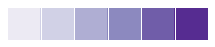

In [128]:
zipcodes = zc_best5['RegionName']
ROI_data = zc_best5['ROI']

print_id = True # The shape id will be printed
color_palette = 1 # 'Purples'
plot_zip_data(sf, 'ROI Zipcodes', zipcodes, ROI_data, color_palette, print_id)

In [129]:
def plot_map_fill_multiples_ids(title, zipcode, sf, 
                                               x_lim = None, 
                                               y_lim = None, 
                                               figsize = (12,10), 
                                               color = 'r'):
    '''
    Plot map with lim coordinates
    '''
    
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in zipcode:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color)
             
        x0 = np.mean(x_lon)
        y0 = np.mean(y_lat)
        plt.text(x0, y0, id, fontsize=10)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [127]:
type(zipcodes)
zipcodes = pd.Series(zipcodes).values

ValueError: Wrong number of items passed 268, placement implies 104

In [ ]:
# zipcode_id = list(zipcodes)
# plot_map_fill_multiples_ids("Top Zipcodes", 
#                             zipcode_id, sf, color = 'r')

In [105]:
zipcodes = NY_df.groupby(['RegionID']).mean()

In [106]:
# reset the index
zipcodes.reset_index(inplace=True)

# Reformat Data 

For time series analysis, we need to change the format from wide to long.

In [107]:
top5_df = pd.DataFrame()
for z in zipcodes:
    d = melt_data(NY_df[NY_df.RegionName==z])
    top5_df = pd.concat([d,top5_df])
top5_df.head()

,RegionID,SizeRank,RegionName,City,State,Metro,CountyName,value
time,,,,,,,,


In [108]:
top5_df['time'] = top5_df.index

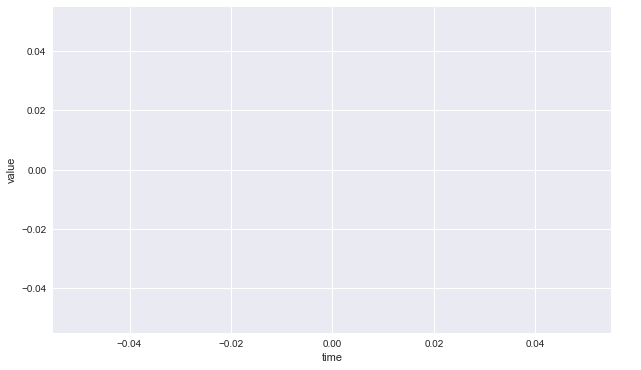

In [109]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x = 'time', y = 'value', hue="RegionName", data=top5_df)
ax.yaxis.set_ticks_position('both')

plt.legend(top5_df['RegionName'].unique(), ncol=1, bbox_to_anchor=(1.05, 1));

In [110]:
top5_df = pd.DataFrame()
for z in zipcodes:
    d = melt_data(NY_df[NY_df.RegionName==z])
    top5_df = pd.concat([d,top5_df])
#top5_df.head()

In [111]:
top5_df.value.plot(figsize=(20,10),label='Values',color='blue',alpha=0.2)
min_ = top5_df.groupby('time').aggregate({'value':'min'})
max_ = top5_df.groupby('time').aggregate({'value':'max'})
mean_ = top5_df.groupby('time').aggregate({'value':'mean'})
plt.plot(min_, color= 'red',label='Min')
plt.plot(max_, color='blue',label = 'Max')
plt.plot(mean_, color= 'black',label= 'Mean')
plt.legend()
plt.title('Home Values In Top New York Zipcodes')
plt.ylabel('Value')
plt.show()
# We can see that there is a low std and an overall positive trend

TypeError: Empty 'DataFrame': no numeric data to plot

Next, we will slice our dataframe so it only include data from 2008 onwards since data from before the financial crisis will not be helpful in forcasting models.

In [ ]:
# Slice the timeseries to contain data after year 2008. 

top5_post2008 = top5_df['2008':]
top5_post2008.head()

Now we will create a separate dataframe for each of the top 5 zipcodes we selected from our real estate criteria. 

In [ ]:
JacksonHeights = top5_post2008.loc[top5_post2008['RegionName']==11372]
Elmhurst = top5_post2008.loc[top5_post2008['RegionName']==11373]
BathBeach = top5_post2008.loc[top5_post2008['RegionName']==11214]
BrightonBeach = top5_post2008.loc[top5_post2008['RegionName']==11235]
Woodside = top5_post2008.loc[top5_post2008['RegionName']==11377]

Let's see a preview of one of our new time series dataframes to make sure the format is optimal for analysis.

In [58]:
JacksonHeights.head()

NameError: name 'JacksonHeights' is not defined

In [59]:
JacksonHeights.drop(columns=['RegionID', 'City', 'State', 'Metro', 'SizeRank', 'CountyName'], inplace=True)
JacksonHeights['time'] = JacksonHeights.index
JacksonHeights.set_index('time',  inplace = True)

NameError: name 'JacksonHeights' is not defined

In [60]:
Elmhurst.drop(columns=['RegionID', 'City', 'State', 'Metro', 'SizeRank', 'CountyName'], inplace=True)
Elmhurst['time'] = Elmhurst.index
Elmhurst.set_index('time',  inplace = True)

NameError: name 'Elmhurst' is not defined

In [ ]:
BathBeach.drop(columns=['RegionID', 'City', 'State', 'Metro', 'SizeRank', 'CountyName'], inplace=True)
BathBeach['time'] = BathBeach.index
BathBeach.set_index('time',  inplace = True)

In [ ]:
BrightonBeach.drop(columns=['RegionID', 'City', 'State', 'Metro', 'SizeRank', 'CountyName'], inplace=True)
BrightonBeach['time'] = BrightonBeach.index
BrightonBeach.set_index('time',  inplace = True)

In [ ]:
Woodside.drop(columns=['RegionID', 'City', 'State', 'Metro', 'SizeRank', 'CountyName'], inplace=True)
Woodside['time'] = Woodside.index
Woodside.set_index('time',  inplace = True)

In [ ]:
Woodside.info()

## Split into Training/Test Sets

Next, let's split each of our datasets into a training set and a testing set in a 80% to 20% ratio which we will use to generate and validate our model.

In [ ]:
# # Confirm how many periods are covered by the dataset
# n = len(JacksonHeights)
# training_n = int(n*0.8)
# print('Number of Obs Training Set: ', training_n)
# print('Number of Obs Test Set: ', n - training_n)

In [ ]:
# training_n

In [ ]:
# def train_test_split(data):
    
#     train = []
#     test = []
    
    
#     for i in range(0, len(data)):
#     #Split datasets into training and testing
#         train_df = data.iloc[:99]
#         test_df = data.iloc[99:]
    
#     #Append training and test datasets to list
#         train.append(train_df)
#         test.append(test_df)
#     return train, test

In [49]:
# # The dataset for each zipcode is split into a training and testing set
# JH_train, JH_test = train_test_split(JacksonHeights)
# Elm_train, Elm_test = train_test_split(Elmhurst)
# Bath_train, Bath_test = train_test_split(BathBeach)
# Bright_train, Bright_test = train_test_split(BrightonBeach)
# WS_train, WS_test = train_test_split(Woodside)

In [50]:
# len(JH_train)

## Check for Stationarity

When working with time series data, most models work on the assumption that the data is **stationary**. This means it's statistical properties (i.e. mean, variance, autocorrelation) remain constant over time. Next we will check to see if our data is stationary or if it shows any trends. 
<br/><br/>
We can do this visually and by using the Dickey-Fuller Test.

In [51]:
#This function is used to address stationarity per zipcode

def stationarityTest(df):
    """
    ts is the time series with time as index and target variable
    wd is the window for the rolling statistics test
    zipcode is the zipcode under analysis
    """
    
    rolmean = df.rolling(window = 12, center = False).mean()
    rolstd = tsZip.rolling(window = 12, center = False).std()
    #plot rolling mean and std against original time series
    fig = plt.figure(figsize = (14, 7))
    orig = plt.plot(df, color ='blue', label = 'Original')
    mean = plt.plot(rolmean, color ='red', label ='Rolling Mean')
    std = plt.plot(rolstd, color ='black', label ='Rolling Std')
    plt.legend(loc ='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Dickey Fuller test only accepts 1d series, therefore we pass the values column only
    dftest = adfuller(df['value'])
    dfoutput = pd.Series(dftest[0:4], index =['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of observation'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value(%s)'%key] = value
    return(dfoutput)

In [52]:
JacksonHeights.info()

NameError: name 'JacksonHeights' is not defined

In [53]:
#Get a list of zipcodes in the selected cities
ziplist = list(top5_df['RegionName'].unique())

In [54]:
stationarityTest(JacksonHeights)

NameError: name 'JacksonHeights' is not defined

In [1141]:
# test each zipcode for stationarity using the AD Fuller Test.
zipcodes = top5_df.RegionName.sort_values().unique()

from statsmodels.tsa.stattools import adfuller
from numpy import log

for z in zipcodes: 
    df_z = top5_df[top5_df.RegionName == z]
    result = adfuller(top5_df.value.dropna())
    print('Zip: ', z)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

NameError: name 'zip_df' is not defined

In [ ]:
data_diff = tsZip.diff(periods=12)


## Check for Seasonality

# ARIMA and SARIMA Modeling

## ACP and PACF 

## ARIMA Modeling

In [8]:
# Define the p, d and q parameters to take any value between 0 and 1
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0],x[1],x[2],12) for x in pdq]

## Forecasting

## SARIMA Modeling

# Results/Business Recommendations

# Future Work